# Fine-Tuning OpenCLIP

This notebook is an implementation of [OpenCLIP](https://github.com/mlfoundations/open_clip) fine-tuning with [WiSE-FT](https://github.com/mlfoundations/wise-ft) method for the Ottoman Nature in Travelogues [(ONiT) project](https://onit.oeaw.ac.at/).

After experimenting with two fine-tuning variants including fine-tuning of a linear classifier on top of OpenCLIP, the current version of the notebook experiments with image similarity and prompt search of the ONiT images with an OpenCLIP model, which has been fine-tuned with a sub-set of the [ICONCLASS AI Test Set](https://iconclass.org/testset/) (contrastive learning).

More detailed documentation & final code follows. WORK IN PROGRESS...

In [1]:
# Import packages
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import torch.distributed as dist
from PIL import Image
import pandas as pd
import os
import numpy as np
import math
import open_clip
from tqdm.notebook import tqdm
import time
from torch.utils.tensorboard import SummaryWriter
import random

## Load pre-trained model

In [2]:
# List available models
#open_clip.list_pretrained()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # If using 1 GPU then use mixed precision training
print(f"Device used: {device}")
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion400m_e31', device=device, jit=False) #Must set jit=False for training

Device used: cuda:0


## Image preprocessing parameters

In [4]:
# Import image preprocessing packages
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# Define custom image preprocessing parameters
BATCH_SIZE = 128
IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
train_val_split_ratio = 0.8 # 80/20 ratio for training/validation data

# Define pad function (add black borders to keep aspect ratio)
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

# Define custom preprocess function
preprocess = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Define preprocess for preview
preprocess_preview = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    #transforms.Normalize(MEAN, STD)
])

# Define preprocess for thumbnail
preprocess_thumb = transforms.Compose([
    SquarePad(),
    transforms.Resize((50, 50)),
])

## Text preprocessing: Load tokenizer

In [5]:
# Import text preprocessing packages
from open_clip import tokenizer

tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [6]:
tokenizer

<function open_clip.tokenizer.tokenize(texts: Union[str, List[str]], context_length: int = 77) -> torch.LongTensor>

## Load data

In [7]:
# Data paths
img_dir = 'images'
data_subset_csv = '~/storage/ONiT-CLIP/data/nature_subset_cleaned4FT_GT.csv'
testset_dir = 'ONiT_data/D16'
testset_csv ='~/storage/ONiT-CLIP/data/ONiT_data/ONiT_D16_multi-label_TESTSET_V1.csv'
onit_data_dir = 'ONiT_data/'
onit_full_csv = '~/storage/ONiT-CLIP/data/ONiT_data/ONiT_cleaned-images_2023-10-06.csv'

In [8]:
# Load CSV file with filenames, captions, and image paths
data_full = pd.read_csv(data_subset_csv, sep='|', na_filter=False)
data_full = data_full.dropna()
testset = pd.read_csv(testset_csv, sep=',', na_filter=False)
onit_data = pd.read_csv(onit_full_csv, sep=',', na_filter=False)

# Load the image paths, filenames, and captions from a CSV file into lists
image_filenames = data_full["filename"].tolist()
image_captions = data_full["annotation"].tolist()
labels = data_full["label"].tolist()
labels_num = []

for label in data_full["class number"]:
    if isinstance(label, int):
        labels_num.append('[', label, ']')
    elif isinstance(label, str):
        # Handle comma-separated values within a string
        label_list = [int(x.strip()) for x in label.split(',') if x.strip().isdigit()]
        labels_num.append(label_list)

from sklearn import preprocessing
mlb = preprocessing.MultiLabelBinarizer()
#mlb.fit(['1', '2', '3', '4'])
labels_num = mlb.fit_transform(labels_num)
labels_num = labels_num[:, :-1]
#print(labels_num)
print(labels_num.shape)
print(len(labels))

(22716, 4)
22716


In [9]:
# Load testset image paths, filenames, and captions from a CSV file into lists
test_filenames = testset["filename"].tolist()
test_labels = testset["label"].tolist()
test_labels_num = []

for label in testset["class number"]:
    if isinstance(label, int):
        test_labels_num.append('[', label, ']')
    elif isinstance(label, str):
        # Handle comma-separated values within a string
        testlabel_list = [int(x.strip()) for x in label.split(',') if x.strip().isdigit()]
        test_labels_num.append(testlabel_list)

test_labels_num = mlb.fit_transform(test_labels_num)
#print(test_labels_num)
print(test_labels_num.shape)
print(len(test_labels))

(407, 4)
407


In [10]:
# Load image paths
image_paths = []
for image_filename in image_filenames:
    img_path = os.path.join(img_dir, image_filename)
    image_paths.append(img_path)

test_img_paths = []
for test_filename in test_filenames:
    test_img_path = os.path.join(testset_dir, test_filename)
    test_img_paths.append(test_img_path)

print(len(image_paths))
print(len(test_img_paths))

22716
407


In [11]:
# Load ONiT data
onit_filenames = []
onit_paths = []
lang_year = []

# Load image paths
for index, row in onit_data.iterrows():
    onit_filename = row["filename"]

    if onit_filename[9] == "_":
        barcode = onit_filename[:9]        
    else:
        barcode = onit_filename[:10]
        
    onit_tag = row["lang_year"]
    onit_path = os.path.join(onit_data_dir, onit_tag, barcode, onit_filename)
    onit_paths.append(onit_path)
    onit_filenames.append(onit_filename)
    lang_year.append(onit_tag)

print(len(onit_filenames))
print(len(onit_paths))

6189
6189


## Define dataset class and data loader

In [12]:
# Define dataset classes
class IconclassDataset(Dataset):
    def __init__(self, image_paths, image_captions, transform=None):
        self.image_paths = image_paths
        self.image_captions = image_captions
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        caption = self.image_captions[idx]
        image_path = self.image_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass
        image_prep = preprocess(image)
        caption_prep = tokenizer(caption)[0]
        return image_prep, caption_prep

class TestDataset(Dataset):
    def __init__(self, image_paths, image_captions, labels, labels_num, transform=None):
        self.image_paths = image_paths
        self.image_captions = image_captions
        self.labels = labels
        self.labels_num = labels_num
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        caption = self.image_captions[idx]
        label = self.labels[idx]
        label_num = self.labels_num[idx]
        image_path = self.image_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass
        image_prep = preprocess(image)
        caption_prep = tokenizer(caption)[0]
        return image_prep, caption_prep, label, label_num

class OnitTest(Dataset):
    def __init__(self, test_img_paths, test_labels, test_labels_num, transform=None):
        self.test_img_paths = test_img_paths
        self.test_labels = test_labels
        self.test_labels_num = test_labels_num
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.test_img_paths)

    def __getitem__(self, idx):
        label = self.test_labels[idx]
        label_num = self.test_labels_num[idx]
        image_path = self.test_img_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass
        image_prep = preprocess(image)
        return image_prep, label, label_num

class OnitFull(Dataset):
    def __init__(self, onit_paths, transform=None):
        self.onit_paths = onit_paths
        self.preprocess = preprocess

    def __len__(self):
        return len(self.onit_paths)

    def __getitem__(self, idx):
        image_path = self.onit_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass
        image_prep = preprocess(image)
        return image_prep

In [13]:
# Define your data loader
dataset = IconclassDataset(image_paths, image_captions)
labels_dataset = TestDataset(image_paths, image_captions, labels, labels_num)
onit_testset = OnitTest(test_img_paths, test_labels, test_labels_num)
onit_full_dataset = OnitFull(onit_paths)
data_loader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

## Split into training and validation data sets
# Total samples length
total_samples = len(image_paths)

# Calculate the sizes of the training and validation sets
train_size = int(train_val_split_ratio * total_samples)
val_size = int((total_samples - train_size)/2)
test_size = int((total_samples - train_size)/2)

# Set a fixed random seed
random_seed = 42
# Use random_split to create training and validation datasets
train_dataset, val_dataset, test_dataset = random_split(labels_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed))
## For fine-tuning of CLIP use dataset (loads image-caption pairs);
## for get_features and classification layer training use labels_dataset (loads images, captions & labels)

# Define your data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
onittest_loader = DataLoader(onit_testset, batch_size=20, shuffle=False)
onitdata_loader = DataLoader(onit_full_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total dataset size: {len(dataset)}')
print(f'Training dataset size: {train_size}')
print(f'Validation dataset size: {val_size}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Batch size: {BATCH_SIZE}')
print(f'Number of batches ICONCLASS training data loader: {len(train_loader)}')
print(f'Number of batches ICONCLASS validation and test data loaders: {len(val_loader)}')
print('----')
print(f'ONiT test dataset size: {len(onit_testset)} -- annotated data, 4 classes')
print(f'ONiT full dataset size: {len(onit_full_dataset)} -- Please note: currently the full dataset contains the testset above!')
print(f'Number of batches ONiT test loader: {len(onittest_loader)}')
print(f'Number of batches ONiT data loader: {len(onitdata_loader)}')
print(f'ONiT test loader batch size: {onittest_loader.batch_size}')

Total dataset size: 22716
Training dataset size: 18172
Validation dataset size: 2272
Test dataset size: 2272
Batch size: 128
Number of batches ICONCLASS training data loader: 142
Number of batches ICONCLASS validation and test data loaders: 18
----
ONiT test dataset size: 407 -- annotated data, 4 classes
ONiT full dataset size: 6189 -- Please note: currently the full dataset contains the testset above!
Number of batches ONiT test loader: 21
Number of batches ONiT data loader: 49
ONiT test loader batch size: 20


## Preview ICONCLASS AI Testset Training Data

In [14]:
import matplotlib.pyplot as plt
import textwrap

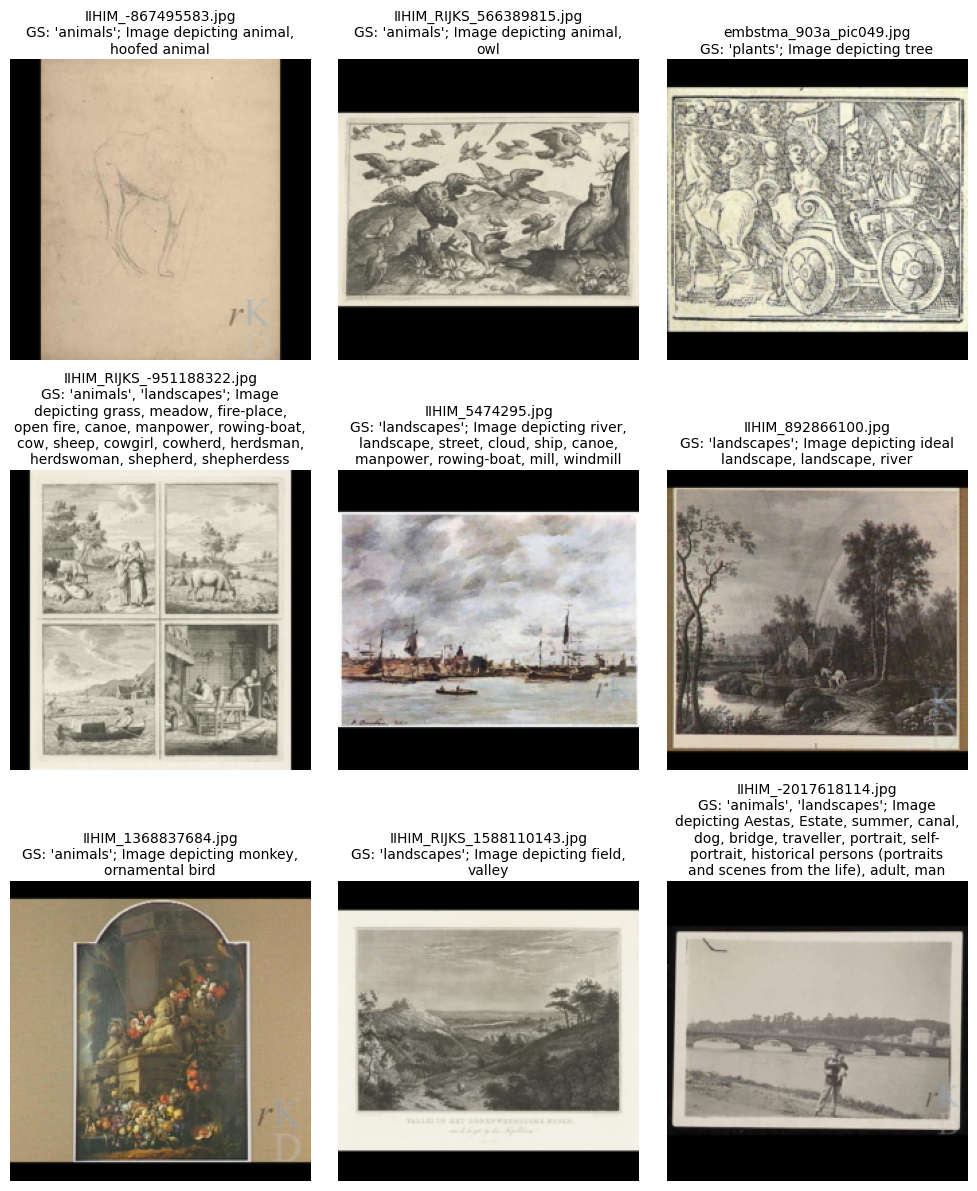

In [15]:
# Define the number of rows and columns in the preview table
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

# Shuffle the indices of the images and captions from the full dataset
indices = list(range(len(image_paths)))
random.shuffle(indices)

# Load the images and captions for the preview and results tables
images = []
indx = []
for i, index in enumerate(indices[:num_images]):
    image = Image.open(image_paths[index]).convert("RGB")
    #print('Image path: ', image_paths[index])
    images.append(image)
    indx.append(index)
    if i == num_images - 1:
        break

# Create lists of captions, filenames, groundtruth, and classnumber of the set of images
captions = [image_captions[index] for index in indices[:num_images]]
filenames = [image_filenames[index] for index in indices[:num_images]]
groundtruth = [labels[index] for index in indices[:num_images]]
#classnumber = [class_number[index] for index in indices[:num_images]]

# Preprocess the images with the torchvision transform
preprocessed_images = torch.stack([preprocess_preview(image) for image in images])

# Create the preview table
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(preprocessed_images[i].permute(1, 2, 0))
    ax.axis("off")
    
    # Add the label as the title
    longtitle = '\n'.join(textwrap.wrap('GS: ' + groundtruth[i] + '; ' + captions[i], width=40))
    filename = filenames[i]
    title = ax.set_title(filename + "\n" + longtitle, fontsize=10, clip_on=True, wrap=True)
    title.set_position([.5, .9])

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5)

# Show the preview table
plt.tight_layout()
plt.show()

## Preview ONiT Testset

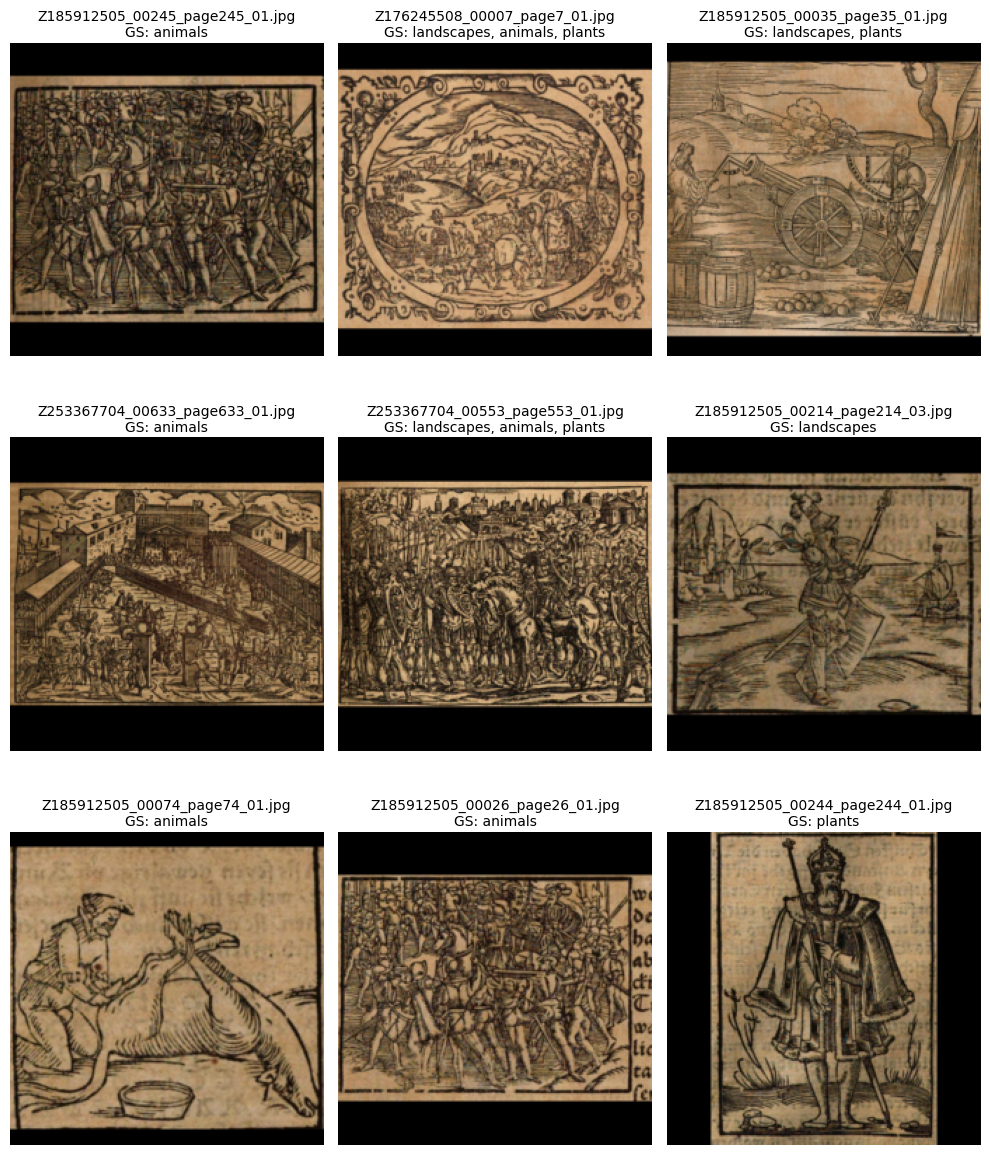

In [16]:
# Define the number of rows and columns in the preview table
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

# Shuffle the indices of the images and captions from the full dataset
indices = list(range(len(test_img_paths)))
random.shuffle(indices)

# Load the images and captions for the preview and results tables
images = []
indx = []
for i, index in enumerate(indices[:num_images]):
    image = Image.open(test_img_paths[index]).convert("RGB")
    #print('Image path: ', image_paths[index])
    images.append(image)
    indx.append(index)
    if i == num_images - 1:
        break

# Create lists of captions, filenames, groundtruth, and classnumber of the set of images
filenames = [test_filenames[index] for index in indices[:num_images]]
groundtruth = [test_labels[index] for index in indices[:num_images]]
#classnumber = [class_number[index] for index in indices[:num_images]]

# Preprocess the images with the torchvision transform
preprocessed_images = torch.stack([preprocess_preview(image) for image in images])

# Create the preview table
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(preprocessed_images[i].permute(1, 2, 0))
    ax.axis("off")
    
    # Add the label as the title
    longtitle = '\n'.join(textwrap.wrap('GS: ' + groundtruth[i], width=40))
    filename = filenames[i]
    title = ax.set_title(filename + "\n" + longtitle, fontsize=10, clip_on=True, wrap=True)
    title.set_position([.5, .9])

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5)

# Show the preview table
plt.tight_layout()
plt.show()

## Fine-tuning parameters

In [17]:
# Finetuning parameters
LR=5e-5 
EPOCHS = 20
num_batches = len(train_loader)
weight_decay=0.2

SAVE_MODEL = 'CLIP-finetune/models/' # Specify path to save fine-tuned model
CACHE_DIR = os.path.join(SAVE_MODEL, "cache/") # Directory for caching features and encoder

# TensorBoard writer
writer = SummaryWriter(log_dir=SAVE_MODEL)

In [18]:
for param in model.parameters():
    param.requires_grad = True # Fine-tune full model without frozen parameters
    
# Freezing selected layers
for name, param in model.named_parameters():
    if 'resblocks.11' in name:
        param.requires_grad = True # Set to true to train selected model parameters
    elif 'resblocks.10' in name:
        param.requires_grad = True # Set to true to train selected model parameters
    else:
        param.requires_grad = False # Freeze all other parameters (set to false)

In [17]:
# Print parameters set for fine-tuning (all other layers are frozen)
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print('Name: ', name, '- Requires_Grad: ', param.requires_grad)

Name:  visual.transformer.resblocks.10.ln_1.weight - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.ln_1.bias - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.attn.in_proj_weight - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.attn.in_proj_bias - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.attn.out_proj.weight - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.attn.out_proj.bias - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.ln_2.weight - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.ln_2.bias - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.mlp.c_fc.weight - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.mlp.c_fc.bias - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.mlp.c_proj.weight - Requires_Grad:  True
Name:  visual.transformer.resblocks.10.mlp.c_proj.bias - Requires_Grad:  True
Name:  visual.transformer.resblocks.11.ln_1.weight - Requires_Grad:  T

In [19]:
# Define optimizer and loss function
params = [p for p in model.parameters() if p.requires_grad] #filters out only the parameters that require gradients, and these are the parameters that the optimizer will update during the training process.
optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss()

In [21]:
class FTModel(nn.Module):
    def __init__(self, model):
        super(FTModel, self).__init__()
        self.model = model

    def forward(self, images, captions):
        image_outputs = self.model.encode_image(images)
        caption_outputs = self.model.encode_text(captions)
        
        #print('Image outputs shape: ', image_outputs.shape)
        #print('Caption outputs shape: ', caption_outputs.shape)
        return image_outputs, caption_outputs

finetune_model = FTModel(model)

print(finetune_model)

FTModel(
  (model): CLIP(
    (visual): VisionTransformer(
      (patchnorm_pre_ln): Identity()
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2): Id

In [22]:
devices = list(range(torch.cuda.device_count()))

## USE THIS TO PARALLELIZE if needed
#model = model.cuda() # Push model to (multiple) GPUs
#model = torch.nn.DataParallel(model, device_ids=devices) # For parallelization on multiple GPUs (wrapper)

print('Using devices', devices)
print('Torch CUDA device count: ', torch.cuda.device_count())

#print(model.train())

Using devices [0]
Torch CUDA device count:  1


# End-to-End Fine-Tuning OpenCLIP

In [ ]:
# Automatic mixed precision fine-tuning end-to-end
scaler = GradScaler()

print('Fine-tuning end-to-end')
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Dataset Size: {train_size}")
model = finetune_model
train_loader = train_loader
val_loader = val_loader

## TRAINING ##
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    # Create the progress bar
    data_loader_iter = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}", leave=True, dynamic_ncols=False)
    
    for batch_idx, (image_prep, caption_prep) in enumerate(data_loader_iter):
        start_time = time.time()
        
        optimizer.zero_grad()

        #caption_prep = caption_prep.unsqueeze(2).unsqueeze(3)
        
        #print(f'Batch {batch_idx +1}:')
        #print(f'Images shape: {image_prep.shape}')
        #print(f'Captions shape: {caption_prep.shape}')
        
        images = image_prep.to(device)
        captions = caption_prep.to(device)
        data_time = time.time() - start_time

        with autocast():
            outputs = model(images, captions)
            #print('Outputs: ', outputs)
            logits_per_image = outputs[0]
            logits_per_caption = outputs[1]
            #print('Logits per image: ', logits_per_image.shape)
            #print('Logits per caption: ', logits_per_caption.shape)
            
            ### Computation of ground_truth and contrastive loss taken from https://github.com/openai/CLIP/issues/83
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            loss = (loss_fn(logits_per_image,ground_truth) + loss_fn(logits_per_caption,ground_truth))/2 # Compute contrastive loss

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        torch.nn.utils.clip_grad_norm_(params, 1.0)
        
        running_loss += loss.item()
        batch_time = time.time() - start_time

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            writer.add_scalar("Training Loss (over the batches)", loss.item(), epoch * len(train_loader) + batch_idx)
            #print("Batch Training Loss", loss.item())
            #print(f"Epoch: {epoch + 1}/{EPOCHS}, Batch: {batch_idx + 1}/{len(train_loader)}")

        if i % 100 == 0:
            percent_complete = 100 * i / len(data_loader)
            print(
                f"Loss: {loss.item():.6f}\tData (t) {data_time:.3f}\tBatch (t) {batch_time:.3f}", flush=True
            )
    running_loss /= len(train_loader)
    # train_accuracy = correct / total

    writer.add_scalar("Training Loss (over the epochs)", running_loss, epoch)
    # writer.add_scalar("Training Accuracy (over the epochs)", train_accuracy, epoch)
    print("\nTraining Loss", running_loss)
    # print("\nTraining Accuracy: ", train_accuracy)

    ## Validation ##
    model.eval()
    val_loss = 0.0

    val_loader_iter = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{EPOCHS}", leave=True, dynamic_ncols=False)

    with torch.no_grad():
        for batch_idx, (image_prep, caption_prep) in enumerate(val_loader_iter):
            images = image_prep.to(device)
            captions = caption_prep.to(device)
            val_time = time.time() - start_time

            outputs = model(images, captions)
            logits_per_image = outputs[0]
            logits_per_caption = outputs[1]

            ### Computation of ground_truth and contrastive loss taken from https://github.com/openai/CLIP/issues/83
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            loss = (loss_fn(logits_per_image,ground_truth) + loss_fn(logits_per_caption,ground_truth))/2 # Compute contrastive loss
            val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(val_loader):
                writer.add_scalar("Validation Loss (over the batches)", loss.item(), epoch * len(val_loader) + batch_idx)

    val_loss /= len(val_loader)
    # val_accuracy = correct / total
    
    writer.add_scalar("Validation Loss (over the epochs)", val_loss, epoch)
    # writer.add_scalar("Validation Accuracy (over the epochs)", val_accuracy, epoch)
    print("\nValidation Loss", val_loss)
    # print("\nValidation Accuracy: ", val_accuracy)

In [ ]:
#%load_ext tensorboard

#%tensorboard --logdir=SAVE_MODEL

In [ ]:
# Save the fine-tuned model

os.makedirs(SAVE_MODEL, exist_ok=True)

if freeze_encoder == True:
    finetuned_model = ImageClassifier(image_encoder, model)
    print('Saving model to ', SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt")
    torch.save(finetuned_model, os.path.join(SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt"))
    
else:
    print('Saving model to ', SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt")
    torch.save(model, os.path.join(SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt"))


## Interpolate fine-tuned and zero-shot weights (WiSE-FT)

In [ ]:
# interpolation coefficient
alpha = 0.5

'Interpolation coefficient for ensembling. '
'Users should specify N-1 values, where N is the number of '
'models being ensembled. The specified numbers should sum to '
'less than 1. Note that the order of these values matter, and '
'should be the same as the order of the classifiers being ensembled.'

In [ ]:
# Load fine-tuned and zero-shot model checkpoints

if freeze_encoder == True:
    print('Load fine-tuned linear classifier checkpoint')
    finetuned_checkpoint = os.path.join(SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt")
    zeroshot = zeroshot_custom

else:
    print('Load fine-tuned full model checkpoint')
    finetuned_checkpoint = os.path.join(SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt")
    zeroshot = FTModel(open_clip.create_model('ViT-B-32', pretrained='laion400m_e31', device=device, jit=False))

finetuned = torch.load(finetuned_checkpoint)

In [ ]:
print(finetuned)

In [ ]:
print(len(zeroshot.state_dict().keys()))
print(len(finetuned.state_dict().keys()))

In [ ]:
# Compute interpolation
theta_0 = zeroshot.state_dict()
theta_1 = finetuned.state_dict()

# make sure checkpoints are compatible
assert set(theta_0.keys()) == set(theta_1.keys())

# interpolate between checkpoints with mixing coefficient alpha
theta = {
    key: (1-alpha) * theta_0[key] + alpha * theta_1[key]
    for key in theta_0.keys()
}

# update the model acccording to the new weights
finetuned.load_state_dict(theta)


In [ ]:
# save model
if freeze_encoder == True:
    print('Saving interpolated model to ', SAVE_MODEL, f'wise_ft_linear_alpha={alpha:.3f}.pt')
    torch.save(finetuned, os.path.join(SAVE_MODEL, f'wise_ft_linear_alpha={alpha:.3f}.pt'))

else:
    print('Saving interpolated model to ', SAVE_MODEL, f'wise_ft_full_alpha={alpha:.3f}.pt')
    torch.save(finetuned, os.path.join(SAVE_MODEL, f'wise_ft_full_alpha={alpha:.3f}.pt'))

# Apply Fine-Tuned OpenCLIP Model
## Get Features of ONiT Dataset

In [24]:
# Load fine-tuned model

finetuned_checkpoint = os.path.join(SAVE_MODEL, "finetune_full_all-resblocks10-11_frozen_20epochs/wise_ft_full_alpha=0.500.pt")
#finetuned_checkpoint = os.path.join(SAVE_MODEL, "finetune_full_all-resblocks11_frozen_20epochs/wise_ft_full_alpha=0.500.pt")
#finetuned_checkpoint = os.path.join(SAVE_MODEL, "finetune_full_no_frozen_params_20epochs/wise_ft_full_alpha=0.500.pt")

model = torch.load(finetuned_checkpoint)

# Load pre-trained model
#model, _, _ = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion400m_e31', device=device)

In [25]:
# Get features of ONiT dataset with loaded image encoder of fine-tuned/pre-trained model

# Get Features function
def get_features(onit_full_dataset):
    image_features = []

    with torch.no_grad():
        for image_prep in tqdm(onitdata_loader):
            #print('Images: ', image_prep.shape)
            imfeat = model.model.encode_image(image_prep.to(device)) ## Fine-tuned model
            #imfeat = model.encode_image(image_prep.to(device)) ## Pre-trained model
            
            image_features.append(imfeat)

    return torch.cat(image_features).cpu().numpy()

# Calculate image features
image_features = get_features(onit_full_dataset)

  0%|          | 0/49 [00:00<?, ?it/s]

In [54]:
np.save('CLIP-finetune/models/cache/onit_full_image_embeddings.npy', image_features)

## Search for similar images

In [26]:
loaded_image_features = np.load('CLIP-finetune/models/cache/onit_full_image_embeddings.npy')

In [27]:
loaded_image_features.shape

(6189, 512)

In [60]:
# Image similarity
from sklearn.metrics.pairwise import cosine_similarity

image_embeddings = torch.tensor(loaded_image_features, device='cpu')

# Compute the cosine similarity between the query image and all other images
def search_similar_images(query_image_embedding, dataset_embeddings):
    similarities = cosine_similarity(query_image_embedding.unsqueeze(0), dataset_embeddings)
    return similarities[0]

# Example: Let's say you want to search for similar images to the first image in the dataset
target_value = 'Z15958790X_00113_page113_01.jpg' # man on horse
#target_value = 'Z15958790X_00163_page163_01.jpg' # man with turban
#target_value = 'Z160260500_00389_page389_01.jpg' # man with hat
#target_value = 'Z15958790X_00177_page177_01.jpg' # ornament
#target_value = 'Z160260500_00325_page325_02.jpg' # illustrated letter
#target_value = 'Z159588009_00113_page113_01.jpg' # reused print

query_image_index = onit_data[onit_data['filename'] == target_value].index

#if not query_image_index.empty:
#    print(f"The index of {target_value} in the 'filename' column is: {query_image_index[0]}")
#else:
#    print(f"{target_value} not found in the 'filename' column.")
#print(query_image_index)

query_image_embedding = image_embeddings[query_image_index[0]]

similarities = search_similar_images(query_image_embedding, image_embeddings)
similarities_tensor = torch.tensor(similarities, device='cpu')

# Sort the images based on similarity (descending order)
similar_images_indices = torch.argsort(similarities_tensor, descending=True)

# Print the indices of the top N similar images
top_n = 16
print(f"Top {top_n} similar images to the query image:")
for i in range(top_n):
    print(f"Image index: {similar_images_indices[i]}, Similarity: {similarities[similar_images_indices[i]]:.4f}")

Top 16 similar images to the query image:
Image index: 92, Similarity: 1.0000
Image index: 81, Similarity: 0.9720
Image index: 79, Similarity: 0.9714
Image index: 109, Similarity: 0.9600
Image index: 115, Similarity: 0.9523
Image index: 691, Similarity: 0.9438
Image index: 909, Similarity: 0.9434
Image index: 654, Similarity: 0.9405
Image index: 5263, Similarity: 0.9388
Image index: 1941, Similarity: 0.9373
Image index: 758, Similarity: 0.9329
Image index: 478, Similarity: 0.9301
Image index: 406, Similarity: 0.9291
Image index: 1422, Similarity: 0.9285
Image index: 426, Similarity: 0.9274
Image index: 616, Similarity: 0.9271


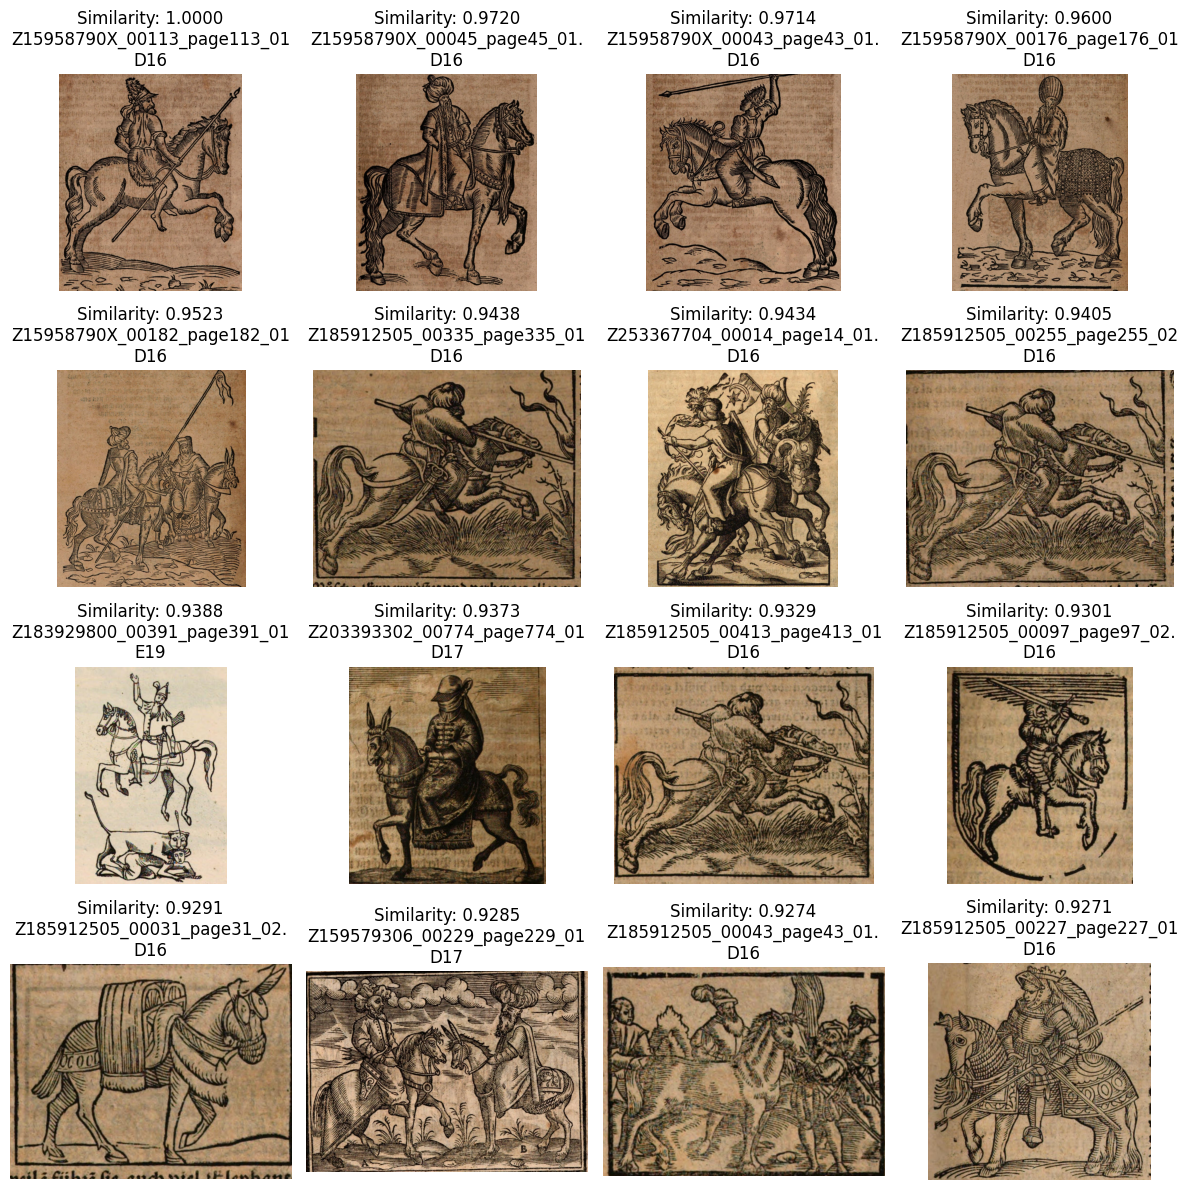

In [61]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the images for visualization
## Note: the first image with similarity 1.0 is the reference image
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i in range(top_n):
    index = similar_images_indices[i].item()
    #print(onit_filenames[index])
    image_path = onit_paths[index]
    image = Image.open(image_path)
    
    # Plot the image
    axes[i // 4, i % 4].imshow(image)
    axes[i // 4, i % 4].axis("off")
    axes[i // 4, i % 4].set_title(f"Similarity: {similarities_tensor[similar_images_indices[i]]:.4f}\n{(onit_filenames[index])[:27]}\n{(lang_year[index])}")

plt.tight_layout()
plt.show()

torch.Size([1, 512])
torch.Size([6189, 512])


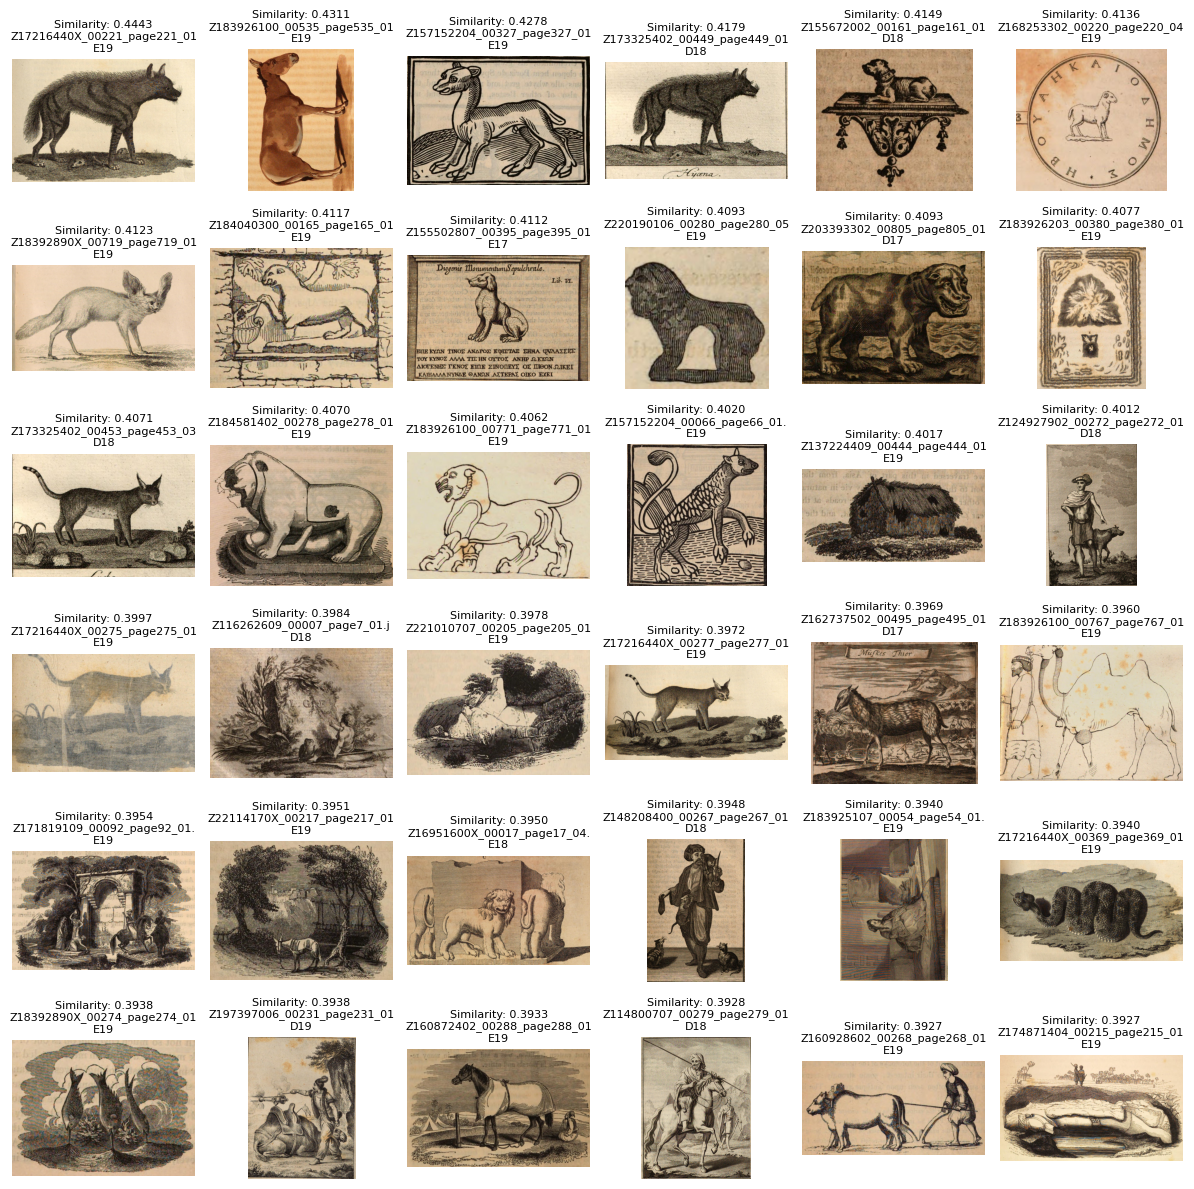

In [66]:
# Text prompt describing the type of images you are looking for
#text_prompt = "An image of a man on a horse"
#text_prompt = "An image of a man with turban"
#text_prompt = "An image of an animal"
#text_prompt = "An image of a citiy landscape"
text_prompt = "An image of a dog"
#text_prompt = "An image of a camel"
#text_prompt = "An image of a map"

# Encode the text prompt to get the text embedding
with torch.no_grad():
    text_embedding = model.model.encode_text(tokenizer(text_prompt).to(device))

print(text_embedding.shape)
print(image_embeddings.shape)

# Compute the cosine similarity between the text prompt and all images
similarities = cosine_similarity(text_embedding.cpu(), image_embeddings.cpu())
similarities_tensor = torch.tensor(similarities[0], device=device)

# Sort the images based on similarity (descending order)
similar_images_indices = torch.argsort(similarities_tensor, descending=True)

# Load the images for visualization
top_n = 36  # Show the top 16 similar images
fig, axes = plt.subplots(6, 6, figsize=(12, 12))

for i in range(top_n):
    index = similar_images_indices[i].item()
    image_path = onit_paths[index]
    image = Image.open(image_path)
    
    # Plot the image
    axes[i // 6, i % 6].imshow(image)
    axes[i // 6, i % 6].axis("off")
    
    # Set the title with two lines
    axes[i // 6, i % 6].set_title(f"Similarity: {similarities_tensor[similar_images_indices[i]]:.4f}\n{(onit_filenames[index])[:27]}\n{(lang_year[index])}", fontsize=8)

plt.tight_layout()
plt.show()

## Generate captions with fine-tuned/zero-shot model

In [33]:
# TODO -- Generate captions with loaded model

captions = []

image_features = torch.tensor(loaded_image_features, device=device)
image_features = image_features.to(torch.long)

for image_feature in image_features:
    with torch.no_grad(), torch.cuda.amp.autocast():
        generated = model.model.encode_text(image_feature)
        caption = open_clip.decode(generated[0].split("<end_of_text>")[0].replace("<start_of_text>", ""))

    captions.append(caption)

print(captions)


# Evaluation

In [47]:
# Get features with loaded image & text encoders of fine-tuned model as input for fine-tuning the linear classifier

# Get Features function
def get_features(val_dataset):
    image_features = []
    text_features = []
    labels_num = []
    labels = []

    with torch.no_grad():
        for image_prep, caption_prep, label, label_num in tqdm(val_loader):
            #print('Images: ', image_prep.shape)
            #print('Captions: ', caption_prep.shape)
            #print('Labels: ', len(label_num))
            imfeat = model.model.encode_image(image_prep.to(device)) ## Fine-tuned model
            capfeat = model.model.encode_text(caption_prep.to(device)) ## Fine-tuned model
            #imfeat = model.encode_image(image_prep.to(device)) ## Pre-trained model
            #capfeat = model.encode_text(caption_prep.to(device)) ## Pre-trained model
            
            image_features.append(imfeat)
            text_features.append(capfeat)
            labels_num.append(label_num)
            labels.append(label)

    labels = [item for batch in labels for item in batch]

    return torch.cat(image_features).cpu().numpy(), torch.cat(text_features).cpu().numpy(), torch.cat(labels_num).cpu().numpy(), labels

# Calculate image features
image_features, text_features, labels_num, labels = get_features(val_dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

In [48]:
print(image_features.shape, text_features.shape, labels_num.shape, len(labels))

(2272, 512) (2272, 512) (2272, 4) 2272


In [49]:
# Get features with loaded image encoder of fine-tuned model as input for trained linear classifier

# Get Features function
def get_features_test(test_dataset):
    image_features = []
    text_features = []
    labels_num = []
    labels = []

    with torch.no_grad():
        for image_prep, caption_prep, label, label_num in tqdm(test_loader):
            #print('Images: ', image_prep.shape)
            #print('Labels: ', len(label_num))
            imfeat = model.model.encode_image(image_prep.to(device)) ## Fine-tuned model
            capfeat = model.model.encode_text(caption_prep.to(device)) ## Fine-tuned model
            #imfeat = model.encode_image(image_prep.to(device)) ## Pre-trained model
            #capfeat = model.encode_text(caption_prep.to(device)) ## Pre-trained model
            
            image_features.append(imfeat)
            text_features.append(capfeat)
            labels_num.append(label_num)
            labels.append(label)

    labels = [item for batch in labels for item in batch]

    return torch.cat(image_features).cpu().numpy(), torch.cat(text_features).cpu().numpy(), torch.cat(labels_num).cpu().numpy(), labels

# Calculate image features
test_image_features, test_text_features, test_labels_num, test_labels = get_features_test(test_dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

In [50]:
print(test_image_features.shape, test_labels_num.shape, len(test_labels))

(2272, 512) (2272, 4) 2272


### Visualise label distribution of ICONCLASS test dataset

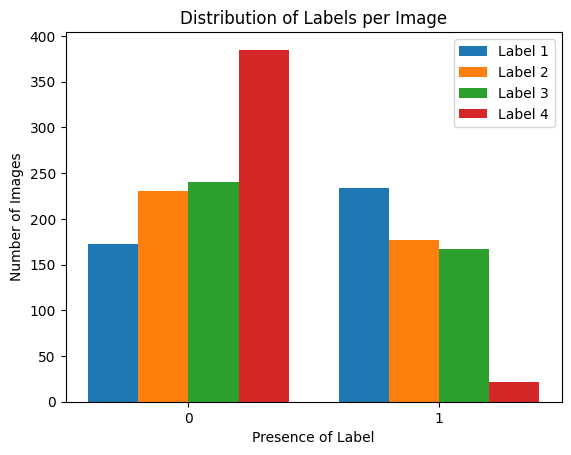

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image
labels_transposed = test_labels_num.T

# Plot separate histograms for each label
fig, ax = plt.subplots()

width = 0.2  # Adjust as needed
for label_idx, label_values in enumerate(labels_transposed):
    unique_values, counts = np.unique(label_values, return_counts=True)
    ax.bar(unique_values + label_idx * width, counts, width=width, label=f'Label {label_idx + 1}')

ax.set_xlabel('Presence of Label')
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Labels per Image')
ax.set_xticks(np.arange(len(unique_values)) + width * (len(labels_transposed) - 1) / 2)
ax.set_xticklabels(unique_values)
ax.legend()

plt.show()

In [35]:
# Common labels

import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image

# Count occurrences of each label across all images
label_counts = np.sum(labels_num, axis=0)

# Display top N common labels
top_n = 4  # Adjust as needed
top_labels = np.argsort(label_counts)[::-1][:top_n]

print(f"Top {top_n} Common Labels:")
for label_idx in top_labels:
    print(f"Label {label_idx + 1}: {label_counts[label_idx]} occurrences")
    

Top 4 Common Labels:
Label 1: 11105 occurrences
Label 3: 8594 occurrences
Label 2: 5752 occurrences
Label 4: 1075 occurrences


In [32]:
# Label co-occurrence

import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image

# Calculate label co-occurrence matrix
label_co_occurrence = np.dot(labels_num.T, labels_num)

print("Label Co-occurrence Matrix:")
print(label_co_occurrence)

# Interpretation:
# - Label 1 appears 11105 times.
# - Label 2 appears 5752 times.
# - Label 3 appears 8594 times.
# - Label 4 appears 1075 times.
# - Labels 1 and 2 co-occur 751 times.
# - Labels 1 and 3 co-occur 2030 times.
# - Labels 1 and 4 co-occur 106 times.
# - Labels 2 and 3 co-occur 1169 times.
# - Labels 2 and 4 co-occur 28 times.
# - labels 3 and 4 co-occur 64 times.

Label Co-occurrence Matrix:
[[11105   751  2030   106]
 [  751  5752  1169    28]
 [ 2030  1169  8594    64]
 [  106    28    64  1075]]


In [33]:
# Label statistics per image

import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image

# Calculate mean, median, and standard deviation of labels per image
mean_labels = np.mean(np.sum(labels_num, axis=1))
median_labels = np.median(np.sum(labels_num, axis=1))
std_labels = np.std(np.sum(labels_num, axis=1))

print(f"Mean Labels per Image: {mean_labels}")
print(f"Median Labels per Image: {median_labels}")
print(f"Standard Deviation of Labels per Image: {std_labels}")

Mean Labels per Image: 1.1677231907025885
Median Labels per Image: 1.0
Standard Deviation of Labels per Image: 0.4115226389255673


### Visualise label distribution of ONIT test dataset

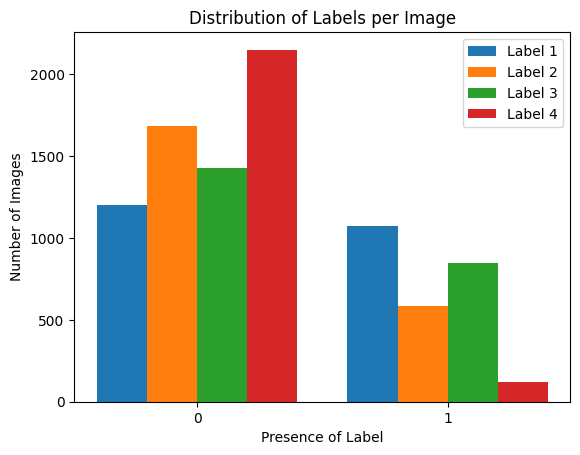

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image
labels_transposed = labels_num.T

# Plot separate histograms for each label
fig, ax = plt.subplots()

width = 0.2  # Adjust as needed
for label_idx, label_values in enumerate(labels_transposed):
    unique_values, counts = np.unique(label_values, return_counts=True)
    ax.bar(unique_values + label_idx * width, counts, width=width, label=f'Label {label_idx + 1}')

ax.set_xlabel('Presence of Label')
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Labels per Image')
ax.set_xticks(np.arange(len(unique_values)) + width * (len(labels_transposed) - 1) / 2)
ax.set_xticklabels(unique_values)
ax.legend()

plt.show()

In [58]:
# Common labels

import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image

# Count occurrences of each label across all images
label_counts = np.sum(labels_num, axis=0)

# Display top N common labels
top_n = 3  # Adjust as needed
top_labels = np.argsort(label_counts)[::-1][:top_n]

print(f"Top {top_n} Common Labels:")
for label_idx in top_labels:
    print(f"Label {label_idx + 1}: {label_counts[label_idx]} occurrences")
    

Top 4 Common Labels:
Label 1: 1073 occurrences
Label 3: 848 occurrences
Label 2: 586 occurrences
Label 4: 123 occurrences


In [59]:
# Label co-occurrence

import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image

# Calculate label co-occurrence matrix
label_co_occurrence = np.dot(labels_num.T, labels_num)

print("Label Co-occurrence Matrix:")
print(label_co_occurrence)

# Interpretation:
# - Label 1 appears 1073 times.
# - Label 2 appears 586 times.
# - Label 3 appears 848 times.
# - Label 4 appears 123 times.
# - Labels 1 and 2 co-occur 77 times.
# - Labels 1 and 3 co-occur 179 times.
# - Labels 1 and 4 co-occur 13 times.
# - Labels 2 and 3 co-occur 110 times.
# - Labels 2 and 4 co-occur 5 times.
# - labels 3 and 4 co-occur 6 times.

Label Co-occurrence Matrix:
[[1073   77  179   13]
 [  77  586  110    5]
 [ 179  110  848    6]
 [  13    5    6  123]]


In [60]:
# Label statistics per image

import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image

# Calculate mean, median, and standard deviation of labels per image
mean_labels = np.mean(np.sum(labels_num, axis=1))
median_labels = np.median(np.sum(labels_num, axis=1))
std_labels = np.std(np.sum(labels_num, axis=1))

print(f"Mean Labels per Image: {mean_labels}")
print(f"Median Labels per Image: {median_labels}")
print(f"Standard Deviation of Labels per Image: {std_labels}")

Mean Labels per Image: 1.1575704225352113
Median Labels per Image: 1.0
Standard Deviation of Labels per Image: 0.4011371318661404
